### 크롤링 - 노래사이트

In [1]:
# 매우 작은 브라우저로 웹사이트의 내용과 정보를 불러 올 수 있다
import requests

# 리퀘스트로 가져온 웹사이트의 내용과 정보를 불러올 수 있다
from bs4 import BeautifulSoup

#대량 데이터 처리시 진행상황을 알 수 있다
from tqdm import tqdm, trange 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 20})
# Window 의 한글 폰트 설정
plt.rc('font',family='Malgun Gothic')
%matplotlib inline

In [2]:
#url sort = p 인기순 

def get_suggestion_list(singers, pages):
    suggestion_list = []
    suggestion_album = []
    singer_list = [] 
    for singer in singers: 
        for page in range(pages): 
            base_url = requests.get("https://music.bugs.co.kr/search/track?q=" + singer+'&flac_only=false&target=ARTIST_TRACK_ALBUM&page='+str(page+1)+'&sort=P')
            if base_url.status_code == 200 : 
                soup = BeautifulSoup(base_url.text, 'html.parser', from_encoding="utf8")
                tags = soup.select('#DEFAULT0 > table > tbody')[0].find_all('tr')
                for tag in tags:
                    suggestion_list.append('https://music.bugs.co.kr/track/'+tag['trackid'])
                    suggestion_album.append('https://music.bugs.co.kr/album/'+tag['albumid'])
                    singer_list.append(singer)
            
    return suggestion_list, suggestion_album, singer_list

In [3]:
def get_suggestion_content(url_list):
    base_url2 = requests.get(url_list)
    soup2 = BeautifulSoup(base_url2.text, 'html.parser', from_encoding="utf8")
    lyrics_list = [] 
    tags1 = soup2.select('#container > header > div')[0].find_all('h1')
    title = tags1[0].get_text(strip=True).replace('(inst.)','')
    tags2 = soup2.select('#container > section.sectionPadding.contents.lyrics > div > div')[0].find_all('xmp')
    try : 
        lyrics = tags2[0].get_text(strip=True).replace('\r\n',' ').replace('\r',' ').replace('\n',' ')
    except : 
        lyrics = '' 
    #container > section.sectionPadding.summaryInfo.summaryTrack > div > div.basicInfo > table > tbody > tr:nth-child(1) > th
    tags3 = soup2.select('#container > section.sectionPadding.summaryInfo.summaryTrack > div > div.basicInfo > table > tbody')[0].find_all('td')
    artist = tags3[0].get_text(strip=True)
    
    #container > section.sectionPadding.summaryInfo.summaryTrack > div > div.etcInfo > span > a > span > em
    tags4 = soup2.select('#container > section.sectionPadding.summaryInfo.summaryTrack > div > div.etcInfo > span > a > span')[0].find_all('em')
    like = tags4[0].get_text(strip=True).replace(',','')

    
    lyrics_list.append(artist)
    lyrics_list.append(title)
    lyrics_list.append(like)
    lyrics_list.append(lyrics)
        
    return lyrics_list 

In [4]:
def get_suggestion_album(url_list):
    base_url2 = requests.get(url_list)
    soup2 = BeautifulSoup(base_url2.text, 'html.parser', from_encoding="utf8")
    info = []
    tags1 = soup2.select('#container > section.sectionPadding.summaryInfo.summaryAlbum > div > div.basicInfo > table')[0].find_all('time')
    datetime = tags1[0].get_text(strip=True)
    #container > section.sectionPadding.summaryInfo.summaryAlbum > div > div.basicInfo > table > tbody > tr:nth-child(4) > td
    tags2 = soup2.select('#container > section.sectionPadding.summaryInfo.summaryAlbum > div > div.basicInfo > table > tbody')[0].find_all('td')
    genre = tags2[4].get_text(strip=True)
       
    info.append(datetime)
    info.append(genre)
        
    return info

In [5]:
def get_data(singer, pages): 
    data1= []
    data2= [] 
    
    suggestion_list = get_suggestion_list(singer,pages)[0]
    info_list = get_suggestion_list(singer,pages)[1]  
    singer_list = get_suggestion_list(singer,pages)[2]
    
    for i, suggestion in tqdm(enumerate(suggestion_list)):
        s = get_suggestion_content(suggestion)
        data1.append(s)
    
    for i, info in tqdm(enumerate(info_list)):
        s = get_suggestion_album(info)
        data2.append(s)
        
    data1 = pd.DataFrame(data1, columns=["Artist","Title","Like","Lyrics"])
    data2 = pd.DataFrame(data2, columns=["Datetime","Genre"])
    data3 = pd.DataFrame(singer_list, columns=["Keyword"])
    data = pd.concat([data3, data1, data2], axis = 1)
    
    return data 

In [6]:
singer = ["Maroon 5"]
data = get_data(singer, 2) #페이지1에 곡 50개 

C:\Users\USER\Anaconda3\lib\site-packages\bs4\__init__.py:185: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
100it [00:49,  2.03it/s]
100it [00:36,  2.71it/s]


In [7]:
data.head(5)

,Keyword,Artist,Title,Like,Lyrics,Datetime,Genre
0,Maroon 5,Maroon 5(마룬 파이브),Memories,6456,Here's to the ones that we got Cheers to the w...,2019.09.20,"팝,어쿠스틱"
1,Maroon 5,Adam Levine(Maroon 5),Lost Stars,17630,Please don't see just a boy Caught up in dream...,2014.07.01,"드라마,영화,팝,음악"
2,Maroon 5,Maroon 5(마룬 파이브),Sugar,13512,I'm hurting baby I'm broken down I need your l...,2014.09.01,"팝 락,모던 락"
3,Maroon 5,Maroon 5(마룬 파이브),Don't Wanna Know (feat. Kendrick Lamar),12151,I don't wanna know know know know Who's taking...,2017.11.03,"팝,일렉트로닉 팝"
4,Maroon 5,Maroon 5(마룬 파이브),What Lovers Do (feat. SZA),10074,Say say say hey hey now baby Oh my my don't pl...,2017.11.03,"팝,일렉트로닉 팝"


In [9]:
#문자형을 숫자형으로 변경 
data['Like'] = data['Like'].astype(int)

data.head(1)

,Keyword,Artist,Title,Like,Lyrics,Datetime,Genre
0,Maroon 5,Maroon 5(마룬 파이브),Memories,6456,Here's to the ones that we got Cheers to the w...,2019.09.20,"팝,어쿠스틱"


In [10]:
data['Lyrics'][0]

"Here's to the ones that we got Cheers to the wish you were here But you're not 'Cause the drinks bring back All the memories Of everything we've been through Toast to the ones here today Toast to the ones that we lost on the way 'Cause the drinks bring back All the memories And the memories bring back Memories bring back you There's a time that I remember When I did not know no pain When I believed in forever And everything would stay the same Now my heart feel like december When somebody say your name 'Cause I can't reach out to call you But I know I will one day yeah Everybody hurts sometimes Everybody hurts someday ayy ayy But everything gon' be alright Go and raise a glass and say ayy Here's to the ones that we got Cheers to the wish you were here But you're not 'Cause the drinks bring back All the memories Of everything we've been through Toast to the ones here today Toast to the ones that we lost on the way 'Cause the drinks bring back All the memories And the memories bring bac

** Text Anlayze 분석 Library Import

In [46]:
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.stem import LancasterStemmer
from nltk.tag import pos_tag
from collections import Counter
import nltk

### Pos Tag / Counter를 이용한 분석

#### Pos : 품사라고 하고, Part of Speech
- 형태소 분석(POS-tagging)이란 원시말뭉치를 형태소 단위로 쪼개고 각 형태소에 품사 정보를 부착하는 작업
- 의미 리스트 : https://dbrang.tistory.com/1245

#### Counter : Collection.Counter 는 컨테이너에 동일한 값의 자료가 몇개인지를 파악하는데 사용하는 객체
- collections.Counter()의 결과값(return)은 딕셔너리 형태로 출력
- reference page : https://excelsior-cjh.tistory.com/94 

In [44]:
### Counter예시

lst = ['aa', 'cc', 'dd', 'aa', 'bb', 'ee']
print(Counter(lst))

Counter({'aa': 2, 'cc': 1, 'dd': 1, 'bb': 1, 'ee': 1})


In [14]:
# pos_tag
pos_tag(word_tokenize(data.Lyrics[0]))

[('Here', 'RB'),
 ("'s", 'VBZ'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('ones', 'NNS'),
 ('that', 'IN'),
 ('we', 'PRP'),
 ('got', 'VBD'),
 ('Cheers', 'NNS'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('wish', 'NN'),
 ('you', 'PRP'),
 ('were', 'VBD'),
 ('here', 'RB'),
 ('But', 'CC'),
 ('you', 'PRP'),
 ("'re", 'VBP'),
 ('not', 'RB'),
 ("'Cause", 'IN'),
 ('the', 'DT'),
 ('drinks', 'NNS'),
 ('bring', 'VBP'),
 ('back', 'RB'),
 ('All', 'PDT'),
 ('the', 'DT'),
 ('memories', 'NNS'),
 ('Of', 'IN'),
 ('everything', 'NN'),
 ('we', 'PRP'),
 ("'ve", 'VBP'),
 ('been', 'VBN'),
 ('through', 'IN'),
 ('Toast', 'NNP'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('ones', 'NNS'),
 ('here', 'RB'),
 ('today', 'NN'),
 ('Toast', 'NNP'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('ones', 'NNS'),
 ('that', 'IN'),
 ('we', 'PRP'),
 ('lost', 'VBD'),
 ('on', 'IN'),
 ('the', 'DT'),
 ('way', 'NN'),
 ("'Cause", 'IN'),
 ('the', 'DT'),
 ('drinks', 'NNS'),
 ('bring', 'VBP'),
 ('back', 'RB'),
 ('All', 'PDT'),
 ('the', 'DT'),
 ('memories', 'NNS'),
 ('And', 'CC

In [40]:
noun = pos_tag(word_tokenize(data.Lyrics[0]))
noun = noun[-10][0]
print(noun)
stemmer = LancasterStemmer()

#noun = text.lower()
#stemmer.stem(noun)

yeah


In [41]:
noun = noun.lower()
stemmer.stem(noun)

'yeah'

In [47]:
stemmer = LancasterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

#### 'NN' 명사형 단어만 추출 - Stopwrods 로 제거 
def get_wordcloud(n):
    lyrics = data.Lyrics
    nouns = []
    for post in lyrics:
        try :
            for noun in pos_tag(word_tokenize(post)):
                if noun[1] == 'NN':
                    noun = noun[0].lower()
            
                    noun = stemmer.stem(noun)
                    if noun not in stopwords:
                        nouns.append(noun)
        except: 
            pass 
    num_top_nouns = n
    
    # 단어 들의 갯수 
    nouns_counter = Counter(nouns)
    print(nouns_counter)
    
    # top 순위 만큼 추출 
    top_nouns = dict(nouns_counter.most_common(num_top_nouns))
    
    return top_nouns 

In [53]:
top_nouns_lyrics = get_wordcloud(10)
print(top_nouns_lyrics)

Counter({'yeah': 146, 'lov': 128, 'night': 120, 'way': 98, 'hom': 72, 'feel': 68, 'tim': 66, 'girl': 63, 'heart': 60, 'noth': 57, 'lif': 53, 'doo': 51, 'baby': 49, 'dark': 47, 'body': 45, 'pleas': 33, 'map': 32, 'everyth': 30, 'gon': 30, 'head': 30, 'morn': 29, 'today': 28, 'bab': 26, 'sum': 26, 'tonight': 25, 'day': 24, 'caus': 24, 'goodby': 23, 'world': 22, 'wait': 22, 'sid': 21, 'someon': 20, 'nobody': 19, 'door': 19, 'phon': 19, 'somebody': 18, 'ya': 18, 'tomorrow': 18, 'mean': 18, 'sweet': 18, 'look': 18, 'strike': 18, 'payphon': 18, 'chang': 18, 'sunshin': 18, 'chant': 18, 'nam': 17, 'reason': 17, 'sun': 17, 'car': 17, 'motherfuck': 17, 'goodnight': 17, 'run': 16, 'sug': 16, 'rain': 16, 'stereo': 16, 'season': 15, 'someth': 15, 'song': 15, 'thing': 14, 'plac': 14, 'brea': 14, 'mind': 14, 'sil': 13, 'pocket': 13, 'dream': 12, 'lie': 12, 'word': 12, 'tattoo': 12, 'show': 12, 'misery': 12, 'let': 11, 'tast': 11, 'shit': 11, 'back': 11, 'mom': 11, 'bed': 10, 'daylight': 10, 'skin': 1

In [50]:
top_nouns_lyrics.keys()

dict_keys(['yeah', 'lov', 'night', 'way', 'hom', 'feel', 'tim', 'girl', 'heart', 'noth'])

In [52]:
top_nouns_lyrics.values()

dict_values([146, 128, 120, 98, 72, 68, 66, 63, 60, 57])

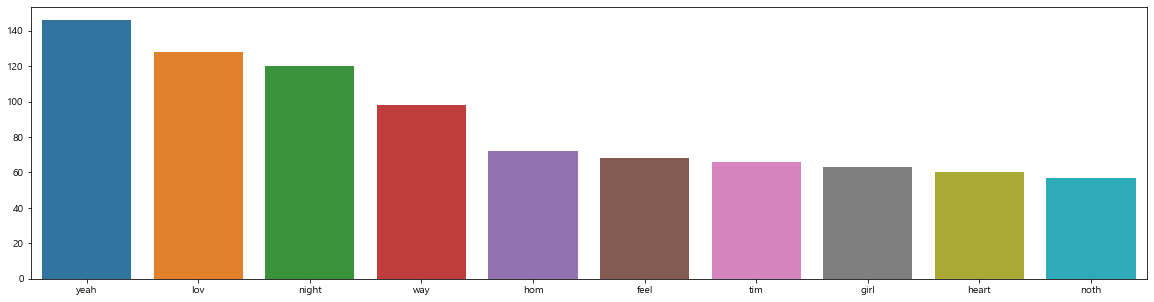

In [54]:
plt.figure(figsize=(20,5))

sns.barplot(y=list(top_nouns_lyrics.values()), x=list(top_nouns_lyrics.keys()))